In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Group_4_data_cleaned.csv",index_col=0)
df.head()

,height,length,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans,y
0,5.0,7,35,1.400,0.400,0.657,2.33,14,23.0,6.0,1
1,6.0,7,42,1.167,0.429,0.881,3.60,18,37.0,5.0,1
2,6.0,18,108,3.000,0.287,0.741,4.43,31,80.0,7.0,1
3,5.0,7,35,1.400,0.371,0.743,4.33,13,26.0,3.0,1
4,6.0,3,18,0.500,0.500,0.944,2.25,9,17.0,4.0,1


In [3]:
print(df.describe())
print(df.info())

            height       length         area        eccen      p_black  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      8.491778    75.944089   678.280833     9.422260     0.355031   
std       2.958167    77.844052   760.273682     9.661801     0.139284   
min       2.500000     1.000000     7.000000     0.007000     0.052000   
25%       7.000000    17.000000   114.000000     2.143000     0.261000   
50%       8.000000    41.000000   322.000000     5.167000     0.337000   
75%      10.000000   107.000000   980.000000    13.625000     0.426000   
max      14.500000   242.000000  2279.000000    30.848000     0.673500   

             p_and      mean_tr     blackpix     blackand     wb_trans  \
count  5473.000000  5473.000000  5473.000000  5473.000000  5473.000000   
mean      0.786324     2.578667   198.322310   492.037365    86.901242   
std       0.166482     1.310313   208.242346   532.593288    92.165275   
min       0.307000     1.000000     7

In [4]:
features = df.columns[:-1]
features = features.to_list()
features

['height',
 'length',
 'area',
 'eccen',
 'p_black',
 'p_and',
 'mean_tr',
 'blackpix',
 'blackand',
 'wb_trans']

In [5]:
output_dict={1:'text',2:'horizontal line',3:'picture',4:'vertical line',5:'graphic'}
df["y"].value_counts().rename(index=output_dict)

text               4913
horizontal line     329
graphic             115
vertical line        88
picture              28
Name: y, dtype: int64

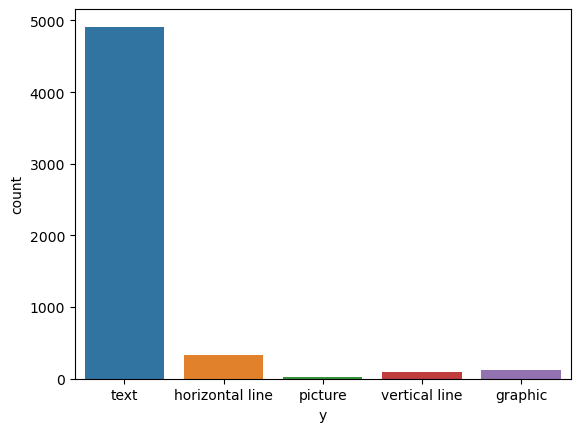

In [6]:
ax = sns.countplot(df['y'])
ax.set(xticklabels=output_dict.values())
plt.show()

In [7]:
X=df.iloc[:, :-1]
y=df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Sequential Forward Floating Selection(sffs)
model=RandomForestClassifier()

sffs = SFS(model,
         k_features=(1,10),
         forward=True,
         floating=True,
         cv=5)
sffs.fit(X_train, y_train)
sffs.k_feature_names_

('length', 'area', 'eccen', 'p_black', 'p_and', 'mean_tr', 'wb_trans')

In [9]:
X = df[list(sffs.k_feature_names_)]
y = df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_train.value_counts()

3    3945
4    3938
5    3924
1    3923
2    3922
Name: y, dtype: int64

In [11]:
rfc = RandomForestClassifier()

random_grid = {"n_estimators": range(10, 51, 10),
               "max_features": ["sqrt", "log2"],
               "max_depth": range(10, 51, 10)
              }

rfc_rs = RandomizedSearchCV(rfc, 
                            param_distributions = random_grid,
                            cv = 5, 
                            n_iter = 100, 
                            scoring = "accuracy")

In [12]:
rfc_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': range(10, 51, 10),
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': range(10, 51, 10)},
                   scoring='accuracy')

In [13]:
print(f"The best hyperparameters: {rfc_rs.best_params_}")
print(f"The best score: {rfc_rs.best_score_}")

The best hyperparameters: {'n_estimators': 40, 'max_features': 'sqrt', 'max_depth': 50}
The best score: 0.9945044252542102


In [14]:
forest = RandomForestClassifier(max_depth = rfc_rs.best_params_['max_depth'],
                                n_estimators = rfc_rs.best_params_['n_estimators'],
                                bootstrap = True,
                                max_features=rfc_rs.best_params_['max_features'])
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', n_estimators=40)

In [15]:
y_pred=forest.predict(X_test)

In [16]:
accuracy_score(y_test,y_pred)

0.9947079177691838

In [17]:
cv_scores = cross_val_score(forest, 
                            X_train, 
                            y_train, 
                            cv=KFold(n_splits=10, shuffle=True),
                            scoring='accuracy')

cv_scores

array([0.99338759, 0.99287894, 0.99694656, 0.99338422, 0.9913486 ,
       0.99694656, 0.99338422, 0.99338422, 0.99389313, 0.99592875])

Average Accuracy 0.9941482816014744
Standard deviation of Accuracy 0.001751439494420922


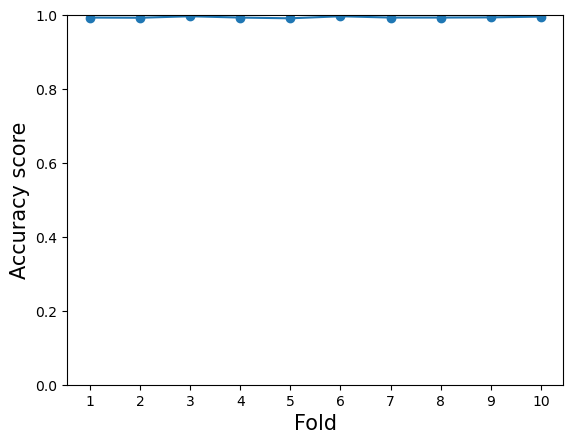

In [18]:
plt.plot(range(1, 11), cv_scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",cv_scores.mean())
print("Standard deviation of Accuracy",cv_scores.std())

In [19]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[981,   5,   1,   2,   1],
       [  0, 984,   0,   7,   0],
       [  0,   0, 968,   0,   0],
       [  0,   0,   0, 975,   0],
       [  0,   0,   0,  10, 979]])

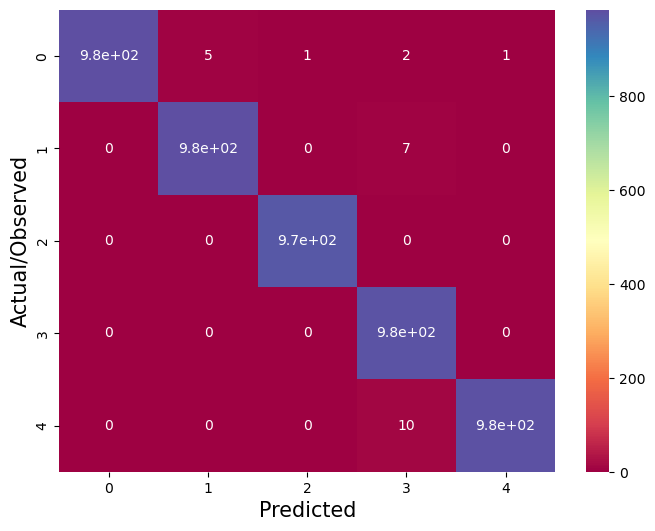

In [20]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);

In [21]:
X=df.iloc[:, :-1]
y=df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

sffs = SFS(model,
         k_features=(1,10),
         forward=True,
         floating=True,
         cv=5)
sffs.fit(X_train, y_train)
sffs.k_feature_names_

('height', 'length', 'p_black', 'p_and', 'mean_tr', 'wb_trans')

In [23]:
X = df[list(sffs.k_feature_names_)]
y = df['y']

oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:

model = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (500,), (1000,)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}
clf = RandomizedSearchCV(model, param_grid)
clf.fit(X_train_scaled,y_train)

RandomizedSearchCV(estimator=MLPClassifier(),
                   param_distributions={'activation': ['relu', 'logistic'],
                                        'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(100,), (200,),
                                                               (500,),
                                                               (1000,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']})

In [25]:
clf.best_params_

{'solver': 'adam',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (500,),
 'alpha': 0.0001,
 'activation': 'relu'}

In [26]:
clf = MLPClassifier(solver = clf.best_params_['solver'],learning_rate = clf.best_params_['learning_rate'],
                    hidden_layer_sizes = clf.best_params_['hidden_layer_sizes'],
                    alpha = clf.best_params_['alpha'],
                    activation = clf.best_params_["activation"])
clf.fit(X_train_scaled,y_train)

MLPClassifier(hidden_layer_sizes=(500,), learning_rate='adaptive')

In [27]:
y_pred=clf.predict(X_test_scaled)

In [28]:
accuracy_score(y_test,y_pred)

0.9788316710767352

In [29]:
cv_scores = cross_val_score(clf, 
                            X_train_scaled, 
                            y_train, 
                            cv=KFold(n_splits=10, shuffle=True),
                            scoring='accuracy')

cv_scores

array([0.9837233 , 0.97863683, 0.98524173, 0.98066158, 0.98015267,
       0.98167939, 0.97302799, 0.97709924, 0.9740458 , 0.98066158])

In [31]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[938,  17,   9,   4,  22],
       [  4, 962,   0,  17,   8],
       [  0,   0, 968,   0,   0],
       [  0,  13,   0, 962,   0],
       [  0,   0,   0,  10, 979]])

Average Accuracy 0.9794930096629987
Standard deviation of Accuracy 0.003698937432996937


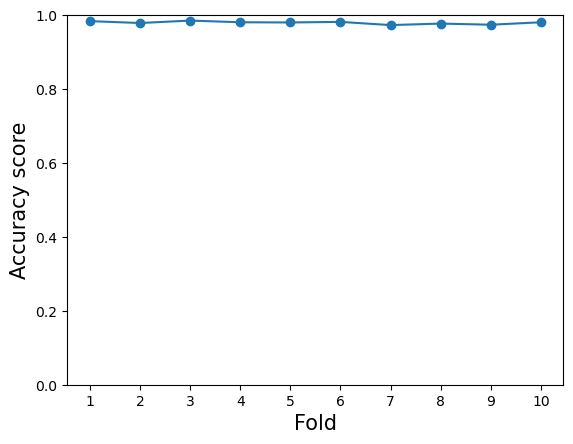

In [30]:
plt.plot(range(1, 11), cv_scores, marker='o')
plt.ylim(0, 1)
plt.ylabel('Accuracy score', fontsize=15)
plt.xlabel('Fold', fontsize=15)
plt.xticks(range(1,11))
print("Average Accuracy",cv_scores.mean())
print("Standard deviation of Accuracy",cv_scores.std())

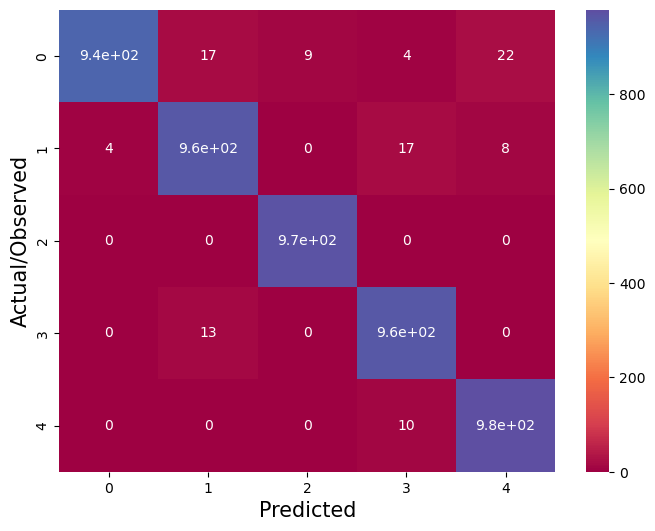

In [32]:
plt.figure(figsize = (8,6))

sns.heatmap(cm, 
            annot=True, 
            cmap="Spectral")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual/Observed', fontsize=15);